# Modeling

## Import data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from pytorch_tcn import TCN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from datetime import datetime
import joblib

In [2]:
url = "https://raw.githubusercontent.com/AsmitC/Austin_Trees/refs/heads/victournguyen/purpleair-pull-data/cleaned_data.csv"
df = pd.read_csv(url)
print(f'Shape: {df.shape}')
df.head()

Shape: (121625, 25)


,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm,sensor_index,latitude,longitude,altitude,...,other,total_diameter,canopy_coverage_percentage,PRCP,year_month,cluster,season_Fall,season_Spring,season_Summer,season_Winter
0,2024-10-24 18:00:00+00:00,35.447,92.044,981.676,2.5,3.2195,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False
1,2024-10-24 06:00:00+00:00,61.950,78.405,984.603,3.6,5.6470,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False
2,2024-10-24 00:00:00+00:00,45.133,83.672,985.485,3.1,4.7600,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False
3,2024-10-23 00:00:00+00:00,48.216,83.123,986.001,2.6,3.9515,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False
4,2024-10-23 18:00:00+00:00,33.578,93.095,985.318,2.5,3.2565,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False


In [3]:
df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})
df.head()

,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm,sensor_index,latitude,longitude,altitude,...,other,total_diameter,canopy_coverage_percentage,PRCP,year_month,cluster,season_Fall,season_Spring,season_Summer,season_Winter
0,2024-10-24 18:00:00+00:00,35.447,92.044,981.676,2.5,3.2195,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0
1,2024-10-24 06:00:00+00:00,61.950,78.405,984.603,3.6,5.6470,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0
2,2024-10-24 00:00:00+00:00,45.133,83.672,985.485,3.1,4.7600,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0
3,2024-10-23 00:00:00+00:00,48.216,83.123,986.001,2.6,3.9515,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0
4,2024-10-23 18:00:00+00:00,33.578,93.095,985.318,2.5,3.2565,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0


## Preprocessing

In [4]:
# Extract time features
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
df['hour'] = df['time_stamp'].dt.hour
df['day_of_week'] = df['time_stamp'].dt.dayofweek
df['month'] = df['time_stamp'].dt.month
df.head()

,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm,sensor_index,latitude,longitude,altitude,...,PRCP,year_month,cluster,season_Fall,season_Spring,season_Summer,season_Winter,hour,day_of_week,month
0,2024-10-24 18:00:00+00:00,35.447,92.044,981.676,2.5,3.2195,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,18,3,10
1,2024-10-24 06:00:00+00:00,61.950,78.405,984.603,3.6,5.6470,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,6,3,10
2,2024-10-24 00:00:00+00:00,45.133,83.672,985.485,3.1,4.7600,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,0,3,10
3,2024-10-23 00:00:00+00:00,48.216,83.123,986.001,2.6,3.9515,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,0,2,10
4,2024-10-23 18:00:00+00:00,33.578,93.095,985.318,2.5,3.2565,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,18,2,10


In [5]:
df.columns

Index(['time_stamp', 'humidity', 'temperature', 'pressure', 'pm2.5_alt',
       'pm2.5_atm', 'sensor_index', 'latitude', 'longitude', 'altitude', 'Oak',
       'Elm', 'Pecan', 'Crape Myrtle', 'Ashe Juniper', 'other',
       'total_diameter', 'canopy_coverage_percentage', 'PRCP', 'year_month',
       'cluster', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'hour', 'day_of_week', 'month'],
      dtype='object')

In [6]:
# Define features and target
features = ['humidity', 'temperature', 'pressure','altitude', 'Oak',
       'Elm', 'Pecan', 'Crape Myrtle', 'Ashe Juniper', 'other',
       'total_diameter', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'latitude', 'longitude', 'canopy_coverage_percentage',
       'PRCP', 'hour', 'day_of_week', 'month']
target = 'pm2.5_alt'

# Drop NA values
before_drop = df.shape[0]
df = df.dropna(subset=features+[target])
after_drop = df.shape[0]
print(f'Lost {(before_drop-after_drop)/before_drop*100:0.2f}% of data by removing NA')

Lost 1.61% of data by removing NA


In [7]:
X = df[features]
y = df[target]

# Split df into training, val, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest

In [8]:
# rf = RandomForestRegressor(
#     n_estimators=250,         # Number of trees in the forest
#     max_depth=20,           # Maximum depth of each tree
#     min_samples_split=4,      # Minimum samples required to split a node
#     min_samples_leaf=2,       # Minimum samples required at a leaf node
#     random_state=42           # Ensures reproducibility
# )
# 
# # Step 2: Fit the model
# rf.fit(X_train, y_train)
# 
# joblib.dump(rf, "./models/rf.pkl", compress=3)
# 
# # Step 3: Make predictions
# y_pred = rf.predict(X_test)
# 
# # Step 4: Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# 
# print(f"Mean Squared Error: {mse}")
# print(f"Mean Absolute Error: {mae}")
# print(f"R^2 Score: {r2}")

In [9]:
rf = joblib.load("./models/rf.pkl")

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 16.134905371515597
Mean Absolute Error: 2.509642410825538
R^2 Score: 0.6184841865664898


# XGBoost

In [10]:
# # Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'max_depth': 11, 'n_estimators': 800, 'subsample': 0.9}
# # Best mse: 12.872662893439998
# best_xgb = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     colsample_bytree=0.9,
#     learning_rate=0.04,
#     max_depth=11,
#     n_estimators=800,
#     subsample=0.9,
#     random_state=42
# )
# best_xgb.fit(X_train, y_train)
# 
# joblib.dump(best_xgb, "./models/xgb.pkl", compress=3)
# 
# # Make predictions
# y_pred_xgb = best_xgb.predict(X_test)
# 
# # Evaluate the model
# mse_xgb = mean_squared_error(y_test, y_pred_xgb)
# mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
# r2_xgb = r2_score(y_test, y_pred_xgb)
# 
# print(f"Mean Squared Error: {mse_xgb}")
# print(f"Mean Squared Error: {mae_xgb}")
# print(f"R^2 Score: {r2_xgb}")

In [11]:
best_xgb = joblib.load("./models/xgb.pkl")

# Make predictions
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Mean Squared Error: {mse_xgb}")
print(f"Mean Squared Error: {mae_xgb}")
print(f"R^2 Score: {r2_xgb}")

Mean Squared Error: 12.876454219140593
Mean Squared Error: 2.133582764030054
R^2 Score: 0.6955314709048508


# Interpretability

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay
import shap

models = [
    # ('Random Forest', rf),
    ('XGBoost', best_xgb)
]

In [13]:
# n_shap = 100
# shap_data_pts = X_train.sample(n=n_shap, random_state=42)
# 
# for n, m in models:
#     n_ = n.replace(' ', '')
#     explainer = shap.Explainer(m)
#     shap_values = explainer(shap_data_pts)
#     joblib.dump(shap_values, f'./shap_values/shap_values_{n_}.pkl', compress=3)

In [14]:
shap_values_list = []

for n, _ in models:
    n_ = n.replace(' ', '')
    shap_values_list.append(joblib.load(f'./shap_values/shap_values_{n_}.pkl'))

In [30]:
for (n, m), shap_values in zip(models, shap_values_list):
    n_ = n.replace(' ', '')

    # Residual plot
    # y_pred = m.predict(X_test)
    # residuals = y_test - y_pred
    # sns.scatterplot(x=y_pred, y=residuals)
    # plt.axhline(0, color='red', linestyle='--')
    # plt.xlabel("Predicted PM2.5")
    # plt.ylabel("Residuals")
    # plt.title(f"Residual Plot ({n})")
    # plt.savefig(f'./plots/residual_plot_{n_}.png', dpi=300, bbox_inches='tight')
    # plt.close()

    # PDP
    tree_types = ['Oak', 'Elm', 'Pecan', 'Crape Myrtle', 'Ashe Juniper', 'other']
    for ft in tree_types:
        PartialDependenceDisplay.from_estimator(m, X, [ft], kind='average')
        ft_ = ft.title()
        plt.title(f'PDP for Number of {ft_} Trees')
        ft_ = ft.replace(' ', '')
        plt.grid(False)
        plt.savefig(f'./plots/pdp_{ft_}_{n_}.png', dpi=300, bbox_inches='tight')
        plt.close()

    # SHAP
    # explainer = shap.Explainer(m)
    # shap_values = explainer(shap_data_pts)
    # shap.plots.waterfall(shap_values[2], show=False)
    # plt.title(f'Example Shapley Value Waterfall Plot')
    # plt.savefig(f'./plots/shap_waterfall_{n_}.png', dpi=300, bbox_inches='tight')
    # plt.close()
    # 
    # shap.plots.beeswarm(shap_values, show=False)
    # plt.title(f'Shapley Value Beeswarm Plot')
    # plt.savefig(f'./plots/shap_beeswarm_{n_}.png', dpi=300, bbox_inches='tight')
    # plt.close()

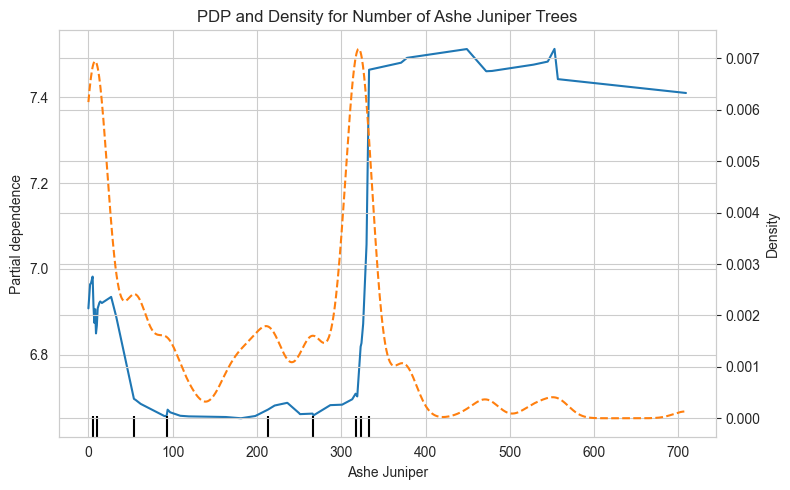

In [32]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from scipy.stats import gaussian_kde
import numpy as np

ft = 'Ashe Juniper'

# Plot the PDP
fig, ax1 = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(best_xgb, X, [ft], kind='average', ax=ax1)
ax1.set_title(f'PDP and Density for Number of {ft} Trees')
# ax1.set_ylabel('PDP')
ax1.set_xlabel(f'Number of {ft} Trees')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid()

# Prepare the density plot
data = X[ft]  # Extracting the 'Oak' column
kde = gaussian_kde(data)
x_density = np.linspace(data.min(), data.max(), 1000)
density = kde(x_density)

# Add the second y-axis for the density plot
ax2 = ax1.twinx()
color_density = 'tab:orange'
ax2.set_ylabel('Density')
density_line, = ax2.plot(x_density, density, color=color_density, linestyle='--', label='Density')
# ax2.fill_between(x_density, density, alpha=0.3, color=color_density)
# ax2.tick_params(axis='y', labelcolor=color_density)

# Manually combine legends
# pdp_line = ax1.get_lines()[0]  # Extract the PDP line from the first axis
# lines = [pdp_line, density_line]
# labels = ['PDP', 'Density']
# ax1.legend(lines, labels, loc='upper left')

# Show the combined plot
plt.tight_layout()
plt.show()

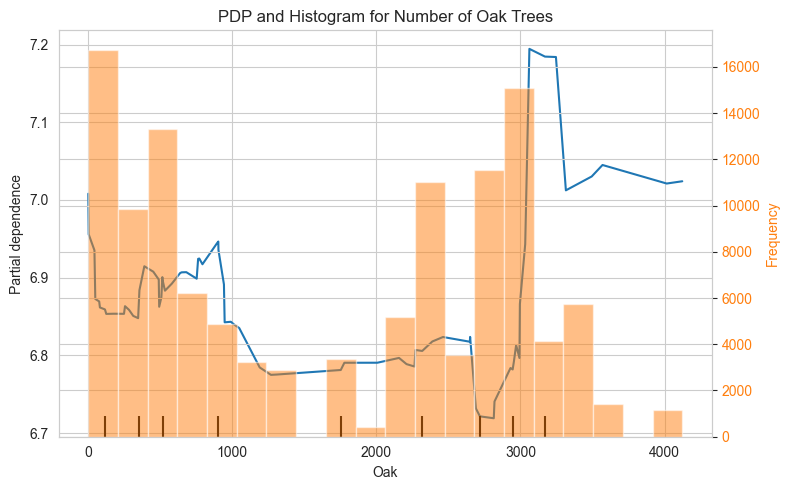

In [23]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import numpy as np

# Assuming best_xgb is your trained model and X is your DataFrame

# Plot the PDP
fig, ax1 = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(best_xgb, X, ['Oak'], kind='average', ax=ax1)
ax1.set_title('PDP and Histogram for Number of Oak Trees')
ax1.set_ylabel('PDP')
ax1.set_xlabel('Number of Oak Trees')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid()

# Add the histogram
data = X['Oak']  # Extracting the 'Oak' column
ax2 = ax1.twinx()
color_hist = 'tab:orange'
ax2.set_ylabel('Frequency', color=color_hist)
n, bins, patches = ax2.hist(data, bins=20, color=color_hist, alpha=0.5, label='Histogram')
ax2.tick_params(axis='y', labelcolor=color_hist)

# # Manually combine legends
# pdp_line = ax1.get_lines()[0]  # Extract the PDP line from the first axis
# lines = [pdp_line, patches[0]]  # Use one of the histogram patches for the legend
# labels = ['PDP', 'Histogram']
# ax1.legend(lines, labels, loc='upper left')

# Show the combined plot
plt.tight_layout()
plt.show()

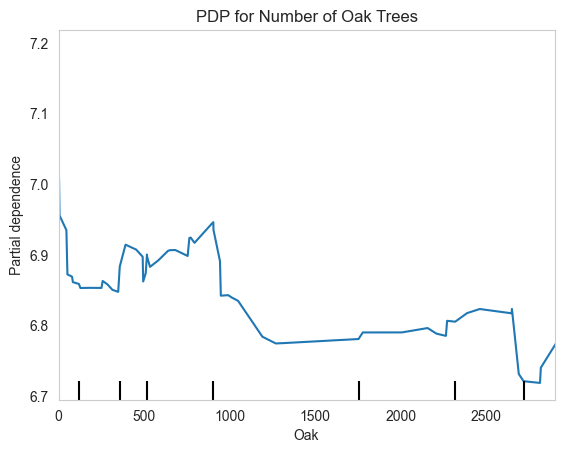

In [27]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Plot the PDP
PartialDependenceDisplay.from_estimator(best_xgb, X, ['Oak'], kind='average')
plt.title('PDP for Number of Oak Trees')

# Crop the x-axis
plt.xlim(0, 2900)

plt.grid(False)

plt.savefig(f'./plots/pdp_Oak.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

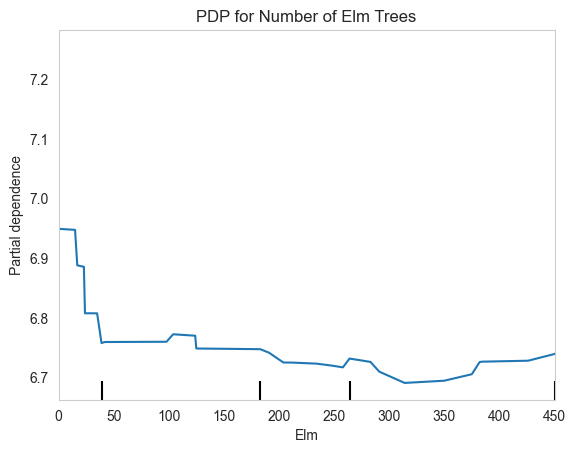

In [28]:
# Plot the PDP
PartialDependenceDisplay.from_estimator(best_xgb, X, ['Elm'], kind='average')
plt.title('PDP for Number of Elm Trees')

# Crop the x-axis
plt.xlim(0, 450)

plt.grid(False)

plt.savefig(f'./plots/pdp_Elm.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

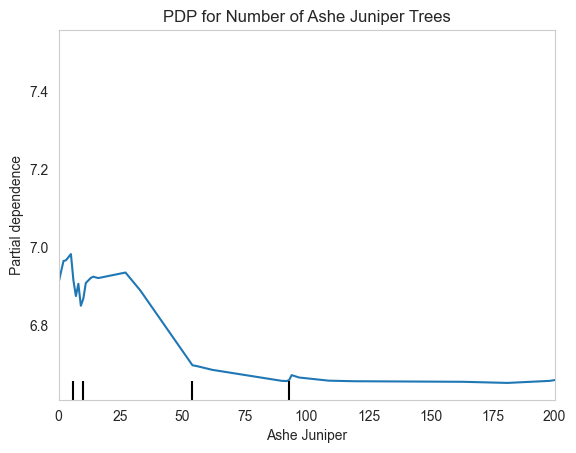

In [29]:
# Plot the PDP
PartialDependenceDisplay.from_estimator(best_xgb, X, ['Ashe Juniper'], kind='average')
plt.title('PDP for Number of Ashe Juniper Trees')

# Crop the x-axis
plt.xlim(0, 200)

plt.grid(False)

plt.savefig(f'./plots/pdp_AsheJuniper.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()